In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
# Change working directory to the root of the project, try to be cautious with this implementation since it will break if the cell is run more than once
os.chdir(r"..")

import pandas as pd
from resources.constants import *
from src import load_dataframes

outfits_df = load_dataframes.load_pickle(DATA_SAVE_PATH, OUTFITS_PATH)
pictures_df = pd.read_csv(PICTURE_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)
user_triplets_df = pd.read_csv(USER_ACTIVITY_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)

outfit_id_to_outfit_group_dict = outfits_df.groupby("id").first().reset_index().set_index("id")[["group"]].to_dict()["group"]
# For the purposes of this notebook, we're not interested in duplicate outfits
outfits_df = outfits_df.groupby("group").first().reset_index()

In [2]:
import numpy as np

def get_outfit_category(tag_categories, tags, category):
    tag_categories, tags = np.array(tag_categories), np.array(tags)
    category_indexes = np.where(tag_categories == category)[0]
    if len(category_indexes) == 0:
        return []
    cat_tags = tags[category_indexes]
    return cat_tags

outfits_df["category"] = outfits_df.apply(lambda x: get_outfit_category(x["tag_categories"], x["outfit_tags"], "Category"), axis=1)
outfit_category_dict = outfits_df[["id", "category"]].set_index("id").to_dict()["category"]

In [3]:
user_rentals_df = user_triplets_df.groupby("customer.id").agg({"outfit.id": list, "meta.validFrom": list, "derived.bookingTime": list,}).reset_index()
def get_outfit_categories(outfit_ids, outfits_to_categories):
    return [category for outfit_id in outfit_ids for category in outfits_to_categories.get(outfit_id, [])]

user_rentals_df["outfit_categories"] = user_rentals_df["outfit.id"].apply(lambda x: get_outfit_categories(x, outfit_category_dict))
user_rentals_df["num_rentals"] = user_rentals_df["outfit.id"].apply(len)

In [4]:
import pickle

# Load pre-computed embeddings from pickle to outfits_df

PICKLED_DICT_PATH = r"resources\data\dataset\embeddings\EfficientNet_V2_L_final_dict.pkl"
with open(PICKLED_DICT_PATH, "rb") as f:
    embeddings_dict = pickle.load(f)

pictures_df["embedding"] = pictures_df["picture.id"].apply(lambda x: embeddings_dict[x])
# Sort displayorder beforehand to ensure embeddings are in the correct order
pictures_dict = pictures_df.sort_values("displayOrder").groupby("outfit.id").agg({"embedding": list, "displayOrder":list, "picture.id": list}).to_dict()
outfits_to_embeddings_dict = pictures_dict["embedding"]
outfits_to_pictures_id_dict = pictures_dict["picture.id"]
outfits_df["embeddings"] = outfits_df["id"].apply(lambda x: outfits_to_embeddings_dict.get(x, []))
outfits_df["picture_ids"] = outfits_df["id"].apply(lambda x: outfits_to_pictures_id_dict.get(x, []))
outfits_df["num_pictures"] = outfits_df["embeddings"].apply(len)
# Use the first picture as the a representative embedding for the outfit
example_embedding = outfits_df["embeddings"].iloc[0][0]
dummy_embedding = np.zeros_like(example_embedding)
outfits_df["lead_embedding"] = outfits_df["embeddings"].apply(lambda x: x[0] if len(x) > 0 else dummy_embedding)
outfits_df["lead_picture_id"] = outfits_df["picture_ids"].apply(lambda x: x[0] if len(x) > 0 else None)
print(f"{len(outfits_df[outfits_df['num_pictures'] == 0])} of {len(outfits_df)} outfits have no embeddings")

330 of 9791 outfits have no embeddings


In [ ]:
from tqdm.notebook import tqdm

#Find positive examples for each outfit group for triplet loss
user_rentals_df["group"] = user_rentals_df["outfit.id"].apply(lambda x: [outfit_id_to_outfit_group_dict[outfit_id] for outfit_id in x])

outfit_positive_examples_dict = {outfit_id: [] for outfit_id in outfits_df["group"]}
for user_rentals in tqdm(user_rentals_df["group"]):
    for outfit_id in user_rentals:
        user_rentals_without_outfit = [x for x in user_rentals if x != outfit_id]
        outfit_positive_examples_dict[outfit_id].extend(user_rentals_without_outfit)

# Record number of positive examples per outfit, will be useful for debugging and analysis later on
outfits_df["num_positive_examples"] = outfits_df["group"].apply(lambda x: len(outfit_positive_examples_dict[x]))

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

# Filter out tags from undesirable categories and those that are too infrequent
EXCLUDED_TAG_CATEGORIES = ["Category", "brand", "Size"]

def get_outfit_tags(tag_categories, tags, excluded_categories):
    tag_categories, tags = np.array(tag_categories), np.array(tags)
    excluded_indexes = np.where(np.isin(tag_categories, excluded_categories))[0]
    if len(excluded_indexes) == 0:
        return tags, tag_categories
    excluded_tags = np.delete(tags, excluded_indexes)
    excluded_tag_categories = np.delete(tag_categories, excluded_indexes)
    return excluded_tags, excluded_tag_categories

outfits_df[["filtered_tags", "filtered_categories"]] = pd.DataFrame(outfits_df.apply(
    lambda x: get_outfit_tags(x["tag_categories"], x["outfit_tags"], EXCLUDED_TAG_CATEGORIES), 
    axis=1
).tolist(), index=outfits_df.index)

def filter_tags_by_frequency(tag_categories, tags, accepted_tags):
    tag_categories, tags = np.array(tag_categories), np.array(tags)
    included_indexes = np.where(np.isin(tags, accepted_tags))[0]
    return tags[included_indexes], tag_categories[included_indexes]


tag_value_counts = outfits_df["filtered_tags"].explode().value_counts()
tag_value_counts = tag_value_counts[tag_value_counts > 20]

outfits_df[["filtered_tags", "filtered_categories"]] = pd.DataFrame(outfits_df.apply(
    lambda x: filter_tags_by_frequency(x["filtered_categories"], x["filtered_tags"], tag_value_counts.index), 
    axis=1
).tolist(), index=outfits_df.index)

In [7]:

all_tags = outfits_df["filtered_tags"].values.tolist()
mlb = MultiLabelBinarizer()
one_hot_encoded = mlb.fit_transform(all_tags)
outfits_df["one_hot_encoded"] = [np.array(oh_list) for oh_list in one_hot_encoded.tolist()]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

def get_mean_embedding(embeddings):
    embeddings = np.array(embeddings)
    mean_embedding = np.mean(embeddings, axis=0)
    return mean_embedding

def concatenate_embeddings(oh_embeddings, image_embeddings, oh_weighting):
    oh_embeddings = np.array(oh_embeddings) * oh_weighting
    return np.concatenate((oh_embeddings, image_embeddings))

#outfits_df["mean_embeddings"] = outfits_df["embeddings"].apply(lambda x: get_mean_embedding(x))
#one_hot_encoded = np.array(outfits_df["one_hot_encoded"].tolist())
#mean_embeddings = np.array(outfits_df["mean_embeddings"].tolist())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Combine one-hot encoded tags and image embeddings
EMBEDDINGS_COLUMN = "concatenated_embeddings"
outfits_df["concatenated_embeddings"] = outfits_df.apply(lambda x: concatenate_embeddings(x["one_hot_encoded"], x["lead_embedding"], oh_weighting=4), axis=1)
input_embeddings = outfits_df[EMBEDDINGS_COLUMN]#np.concatenate((one_hot_encoded, mean_embeddings), axis=1)
input_embeddings = torch.tensor(input_embeddings.tolist(), dtype=torch.float32).to(device)

# To make calculating the loss easier, we'll create a dictionary mapping outfit group to its embeddings and convert it to a tensor
outfit_group_embeddings_dict = outfits_df.set_index("group")[EMBEDDINGS_COLUMN].to_dict()
for key, value in outfit_group_embeddings_dict.items():
    outfit_group_embeddings_dict[key] = torch.tensor(value, dtype=torch.float32, requires_grad=True).to(device)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

class TripletEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(TripletEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.encoder(x)

def euclidean_distance(x1, x2):
    return (x1 - x2).pow(2).sum(dim=1).sqrt()

def find_triplet_loss_pairs(anchor_index, outfits_df, positive_examples_dict, embeddings_dict):
    anchor_group = outfits_df["group"].iloc[anchor_index]
    positive_options = positive_examples_dict[anchor_group]
    if len(positive_options) == 0:
        return None, None, None
    else:   
        positive_example = np.random.choice(positive_options)
    negative_examples = None
    while negative_examples is None or positive_example in negative_examples:
        negative_examples = np.random.choice(outfits_df["group"].values)

    anchor_embedding = embeddings_dict[anchor_group]
    positive_embedding = embeddings_dict[positive_example]
    negative_embedding = embeddings_dict[negative_examples]
    return anchor_embedding, positive_embedding, negative_embedding

# Hyperparameters
input_dim = input_embeddings.shape[1]
hidden_dim = 256
latent_dim = 128
num_epochs = 50
batch_size = 32
learning_rate = 0.001
margin = 0.1

# Instantiate the model, define the loss function and the optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletEncoder(input_dim, hidden_dim, latent_dim).to(device)
triplet_loss = nn.TripletMarginLoss(margin=margin, p=2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    permutation = torch.randperm(len(outfits_df))
    total_loss = 0
    num_valid_triplets = 0

    for i in tqdm(range(0, len(outfits_df), batch_size), desc="Batches", leave=False):
        indices = permutation[i:i+batch_size]
        
        anchors, positives, negatives = [], [], []
        for idx in indices:
            anchor, positive, negative = find_triplet_loss_pairs(idx.item(), outfits_df, outfit_positive_examples_dict, outfit_group_embeddings_dict)
            if anchor is not None:
                anchors.append(anchor)
                positives.append(positive)
                negatives.append(negative)
        
        if not anchors:
            continue

        # Stack tensors
        anchors = torch.stack(anchors).to(device)
        positives = torch.stack(positives).to(device)
        negatives = torch.stack(negatives).to(device)
        
        anchor_encodings = model(anchors)
        positive_encodings = model(positives)
        negative_encodings = model(negatives)

        loss = triplet_loss(anchor_encodings, positive_encodings, negative_encodings)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_valid_triplets += len(anchors)

    avg_loss = total_loss / num_valid_triplets if num_valid_triplets > 0 else 0
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

# Save the trained encoder
#torch.save(model.state_dict(), 'triplet_encoder_model.pth')

Epochs:   2%|▏         | 1/50 [00:05<04:46,  5.84s/it]

Epoch [1/50], Average Loss: 0.0040


Epochs:   4%|▍         | 2/50 [00:11<04:37,  5.78s/it]

Epoch [2/50], Average Loss: 0.0034


Epochs:   6%|▌         | 3/50 [00:17<04:28,  5.72s/it]

Epoch [3/50], Average Loss: 0.0032


Epochs:   8%|▊         | 4/50 [00:22<04:18,  5.63s/it]

Epoch [4/50], Average Loss: 0.0032


Epochs:  10%|█         | 5/50 [00:28<04:08,  5.51s/it]

Epoch [5/50], Average Loss: 0.0031


Epochs:  12%|█▏        | 6/50 [00:33<04:04,  5.55s/it]

Epoch [6/50], Average Loss: 0.0031


Epochs:  14%|█▍        | 7/50 [00:39<03:57,  5.53s/it]

Epoch [7/50], Average Loss: 0.0030


Epochs:  16%|█▌        | 8/50 [00:44<03:54,  5.57s/it]

Epoch [8/50], Average Loss: 0.0029


Epochs:  18%|█▊        | 9/50 [00:50<03:49,  5.59s/it]

Epoch [9/50], Average Loss: 0.0029


Epochs:  20%|██        | 10/50 [00:56<03:45,  5.63s/it]

Epoch [10/50], Average Loss: 0.0028


Epochs:  22%|██▏       | 11/50 [01:01<03:39,  5.64s/it]

Epoch [11/50], Average Loss: 0.0029


Epochs:  24%|██▍       | 12/50 [01:07<03:37,  5.73s/it]

Epoch [12/50], Average Loss: 0.0029


Epochs:  26%|██▌       | 13/50 [01:13<03:36,  5.84s/it]

Epoch [13/50], Average Loss: 0.0029


Epochs:  28%|██▊       | 14/50 [01:19<03:29,  5.83s/it]

Epoch [14/50], Average Loss: 0.0028


Epochs:  30%|███       | 15/50 [01:25<03:22,  5.77s/it]

Epoch [15/50], Average Loss: 0.0028


Epochs:  32%|███▏      | 16/50 [01:30<03:13,  5.70s/it]

Epoch [16/50], Average Loss: 0.0028


Epochs:  34%|███▍      | 17/50 [01:36<03:06,  5.64s/it]

Epoch [17/50], Average Loss: 0.0028


Epochs:  36%|███▌      | 18/50 [01:41<02:58,  5.59s/it]

Epoch [18/50], Average Loss: 0.0027


Epochs:  38%|███▊      | 19/50 [01:47<02:50,  5.51s/it]

Epoch [19/50], Average Loss: 0.0028


Epochs:  40%|████      | 20/50 [01:53<02:51,  5.73s/it]

Epoch [20/50], Average Loss: 0.0028


Epochs:  42%|████▏     | 21/50 [01:59<02:52,  5.96s/it]

Epoch [21/50], Average Loss: 0.0027


Epochs:  44%|████▍     | 22/50 [02:05<02:45,  5.90s/it]

Epoch [22/50], Average Loss: 0.0027


Epochs:  46%|████▌     | 23/50 [02:11<02:40,  5.94s/it]

Epoch [23/50], Average Loss: 0.0026


Epochs:  48%|████▊     | 24/50 [02:17<02:31,  5.84s/it]

Epoch [24/50], Average Loss: 0.0027


Epochs:  50%|█████     | 25/50 [02:23<02:25,  5.81s/it]

Epoch [25/50], Average Loss: 0.0026


Epochs:  52%|█████▏    | 26/50 [02:28<02:19,  5.83s/it]

Epoch [26/50], Average Loss: 0.0027


Epochs:  54%|█████▍    | 27/50 [02:35<02:21,  6.15s/it]

Epoch [27/50], Average Loss: 0.0026


Epochs:  56%|█████▌    | 28/50 [02:41<02:13,  6.07s/it]

Epoch [28/50], Average Loss: 0.0027


Epochs:  58%|█████▊    | 29/50 [02:47<02:07,  6.06s/it]

Epoch [29/50], Average Loss: 0.0026


Epochs:  60%|██████    | 30/50 [02:53<02:00,  6.00s/it]

Epoch [30/50], Average Loss: 0.0026


Epochs:  62%|██████▏   | 31/50 [02:59<01:52,  5.94s/it]

Epoch [31/50], Average Loss: 0.0026


Epochs:  64%|██████▍   | 32/50 [03:05<01:48,  6.01s/it]

Epoch [32/50], Average Loss: 0.0026


Epochs:  66%|██████▌   | 33/50 [03:11<01:43,  6.08s/it]

Epoch [33/50], Average Loss: 0.0025


Epochs:  68%|██████▊   | 34/50 [03:18<01:39,  6.23s/it]

Epoch [34/50], Average Loss: 0.0025


Epochs:  70%|███████   | 35/50 [03:24<01:32,  6.17s/it]

Epoch [35/50], Average Loss: 0.0025


Epochs:  72%|███████▏  | 36/50 [03:30<01:26,  6.15s/it]

Epoch [36/50], Average Loss: 0.0026


Epochs:  74%|███████▍  | 37/50 [03:36<01:20,  6.18s/it]

Epoch [37/50], Average Loss: 0.0025


Epochs:  76%|███████▌  | 38/50 [03:42<01:12,  6.04s/it]

Epoch [38/50], Average Loss: 0.0025


Epochs:  78%|███████▊  | 39/50 [03:48<01:05,  5.96s/it]

Epoch [39/50], Average Loss: 0.0025


Epochs:  80%|████████  | 40/50 [03:54<00:59,  5.92s/it]

Epoch [40/50], Average Loss: 0.0026


Epochs:  82%|████████▏ | 41/50 [03:59<00:52,  5.84s/it]

Epoch [41/50], Average Loss: 0.0025


Epochs:  84%|████████▍ | 42/50 [04:05<00:45,  5.73s/it]

Epoch [42/50], Average Loss: 0.0024


Epochs:  86%|████████▌ | 43/50 [04:11<00:40,  5.77s/it]

Epoch [43/50], Average Loss: 0.0024


Epochs:  88%|████████▊ | 44/50 [04:17<00:35,  5.91s/it]

Epoch [44/50], Average Loss: 0.0024


Epochs:  90%|█████████ | 45/50 [04:22<00:29,  5.81s/it]

Epoch [45/50], Average Loss: 0.0024


Epochs:  92%|█████████▏| 46/50 [04:28<00:23,  5.78s/it]

Epoch [46/50], Average Loss: 0.0024


Epochs:  94%|█████████▍| 47/50 [04:34<00:17,  5.75s/it]

Epoch [47/50], Average Loss: 0.0024


Epochs:  96%|█████████▌| 48/50 [04:40<00:11,  5.97s/it]

Epoch [48/50], Average Loss: 0.0024


Epochs:  98%|█████████▊| 49/50 [04:48<00:06,  6.52s/it]

Epoch [49/50], Average Loss: 0.0024


Epochs: 100%|██████████| 50/50 [04:54<00:00,  5.89s/it]

Epoch [50/50], Average Loss: 0.0024


In [10]:
import numpy as np
def get_outfit_embeddings(input_embeddings, model):
    with torch.no_grad():
        encoded = model(input_embeddings)
    return encoded

outfit_embeddings = get_outfit_embeddings(input_embeddings, model)
outfits_df["outfit_embeddings"] = [x.tolist() for x in outfit_embeddings]
print(np.stack(outfits_df["outfit_embeddings"].values).shape)

(9791, 128)


In [11]:
# Save the embeddings to file, so we can load them directly into the style quiz
OUTFIT_EMBEDDINGS_DF_PATH = r"resources\data\outfit_embeddings_triplets_df.pkl"
outfits_df.to_pickle(OUTFIT_EMBEDDINGS_DF_PATH)

No. of points: 9791


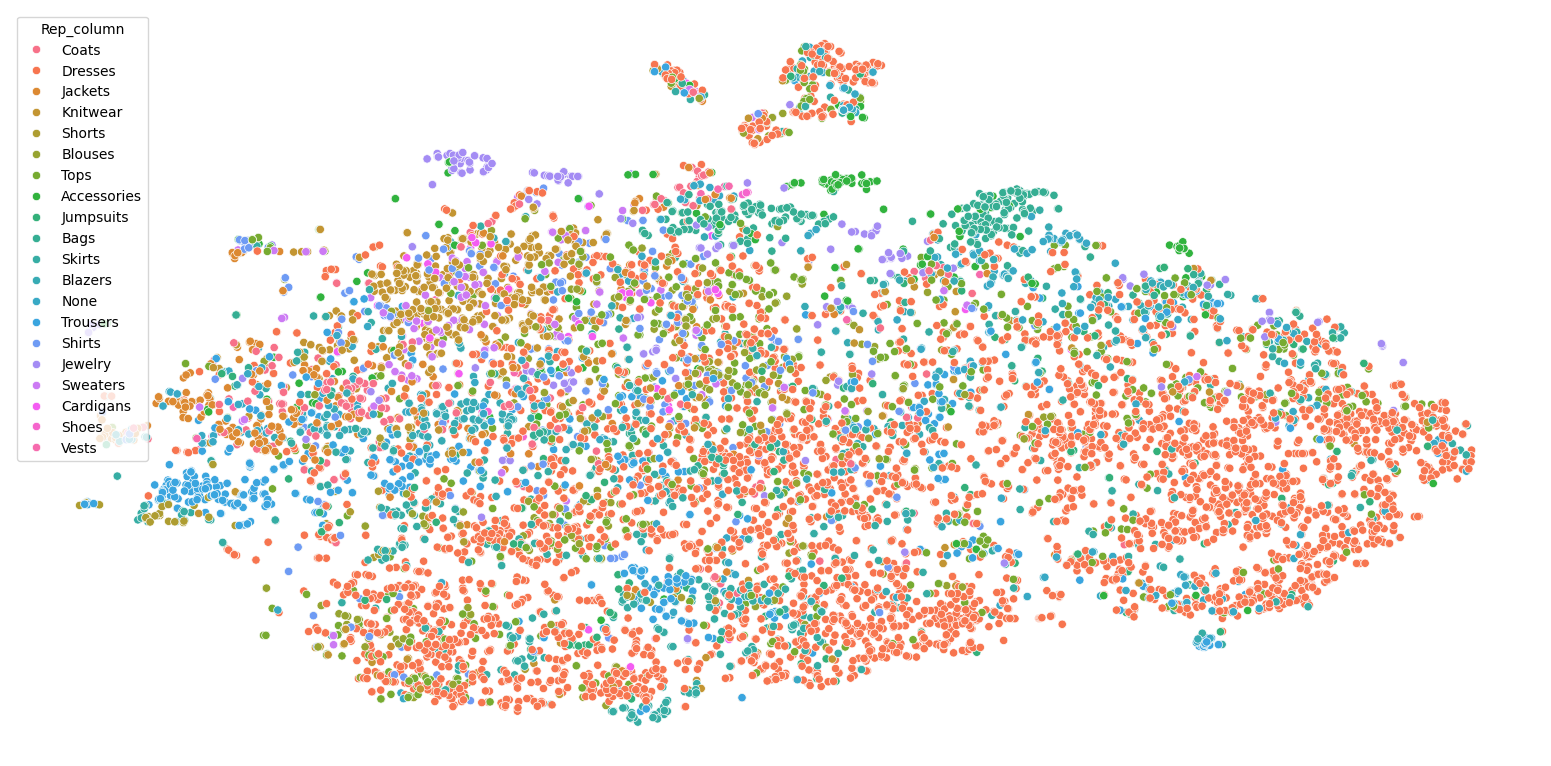

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from src import generate_embedding_tsnes_with_thumbnails

FIGURE_SAVE_PATH = "reports/figures/outfit_tsne.png"

outfits_df["rep_column"] = outfits_df["category"].apply(lambda x: x[0] if len(x) > 0 else "None")

#Generate TSNE diagram of embeddings, but only for outfits with at least one picture
#Save this graph to file to load it into PIL for later editing
tsne_df, scatter_plot = generate_embedding_tsnes_with_thumbnails.generate_tsne_diagram(outfits_df, "outfit_embeddings", hue_column="rep_column", show_plot=True, save_path=FIGURE_SAVE_PATH)

No. of points: 9791


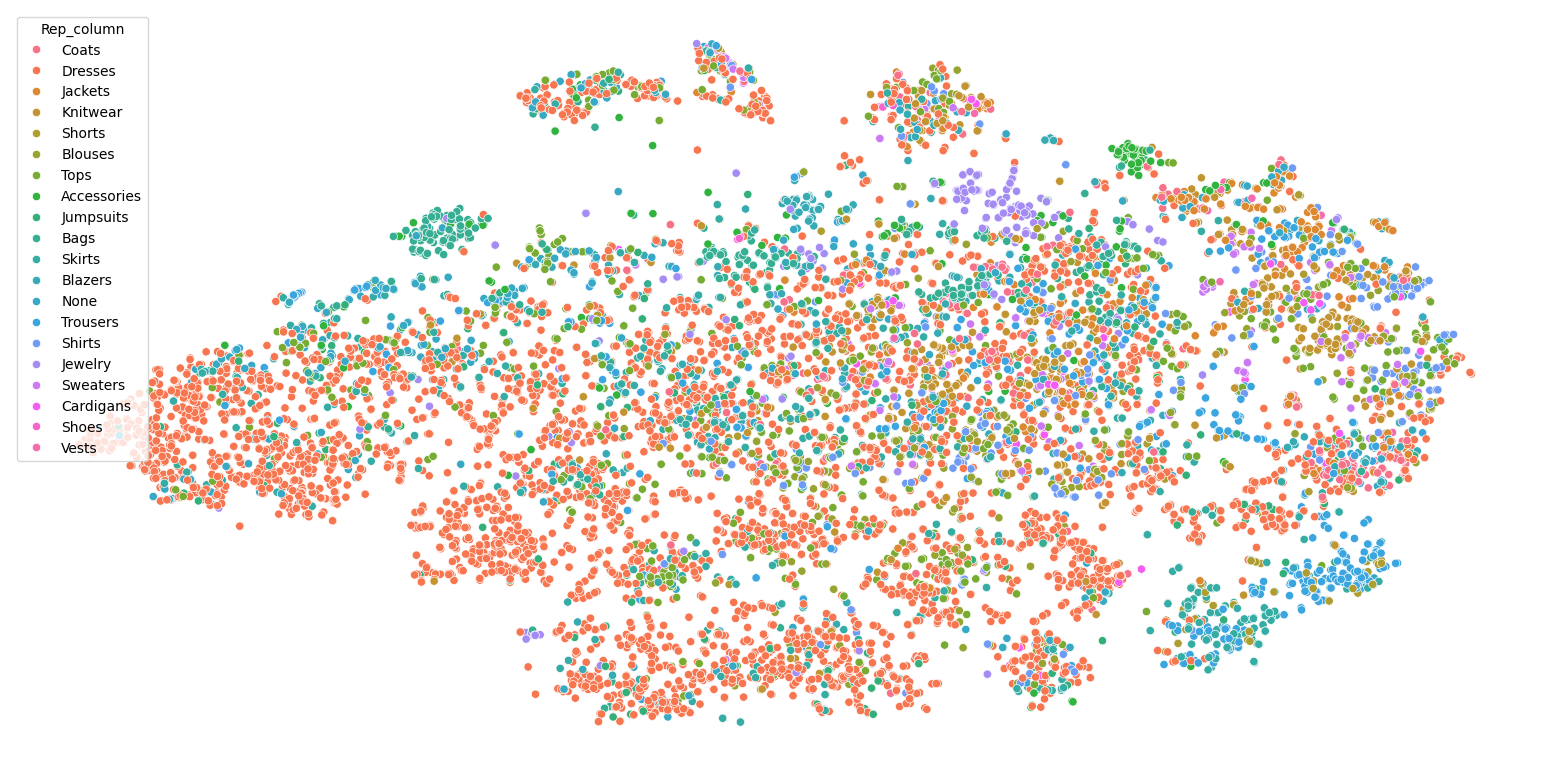

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from src import generate_embedding_tsnes_with_thumbnails

FIGURE_SAVE_PATH = "reports/figures/outfit_tsne.png"

outfits_df["rep_column"] = outfits_df["category"].apply(lambda x: x[0] if len(x) > 0 else "None")

#Generate TSNE diagram of embeddings, but only for outfits with at least one picture
#Save this graph to file to load it into PIL for later editing
tsne_df, scatter_plot = generate_embedding_tsnes_with_thumbnails.generate_tsne_diagram(outfits_df, "outfit_embeddings", hue_column="rep_column", show_plot=True, save_path=FIGURE_SAVE_PATH)

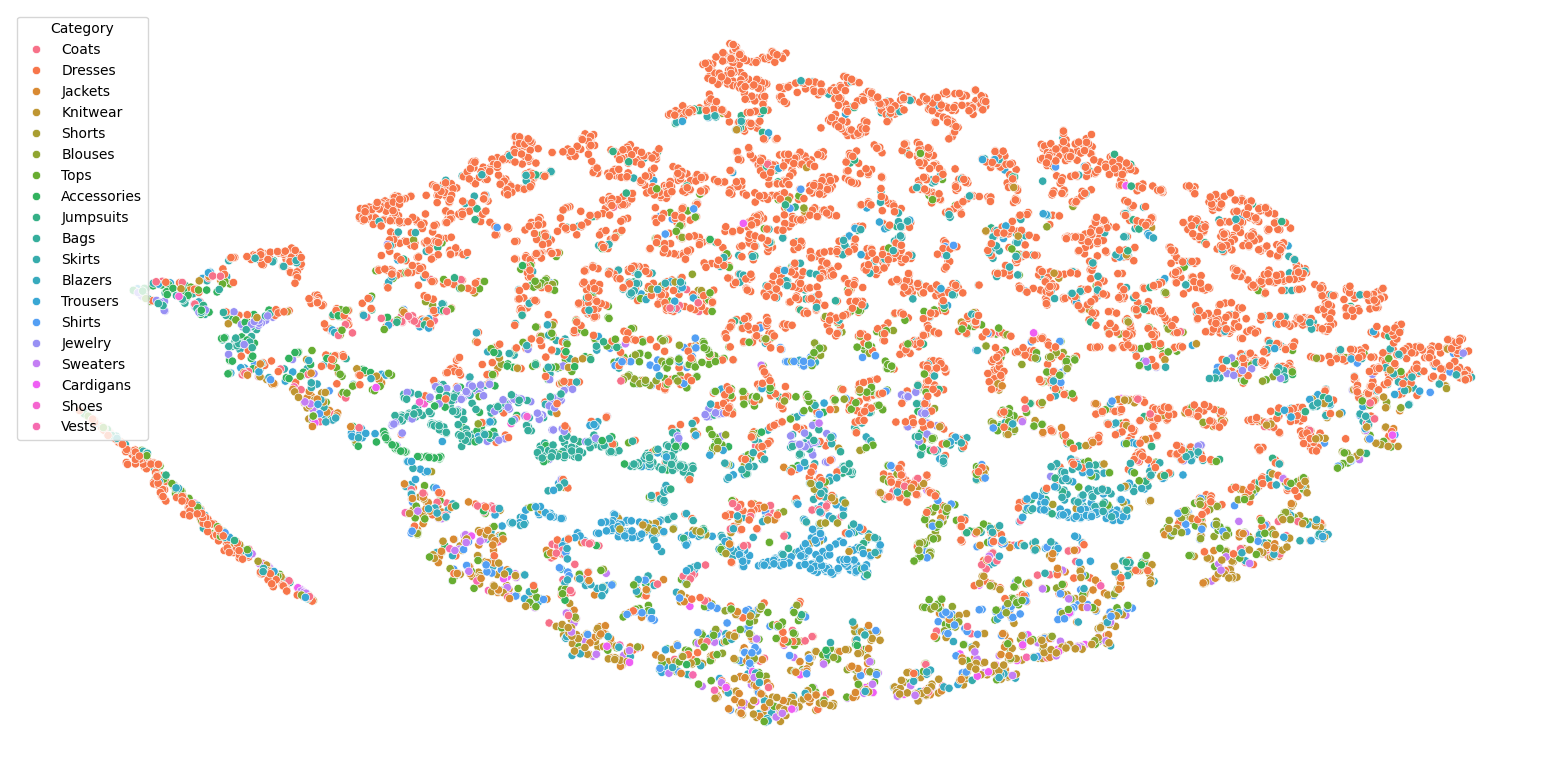

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from src import generate_embedding_tsnes_with_thumbnails

FIGURE_SAVE_PATH = "reports/figures/outfit_tsne.png"

#Generate TSNE diagram of embeddings, but only for outfits with at least one picture
#Save this graph to file to load it into PIL for later editing
tsne_df, scatter_plot = generate_embedding_tsnes_with_thumbnails.generate_tsne_diagram(outfits_df, "outfit_embeddings", show_plot=True, save_path=FIGURE_SAVE_PATH)

0it [00:00, ?it/s]

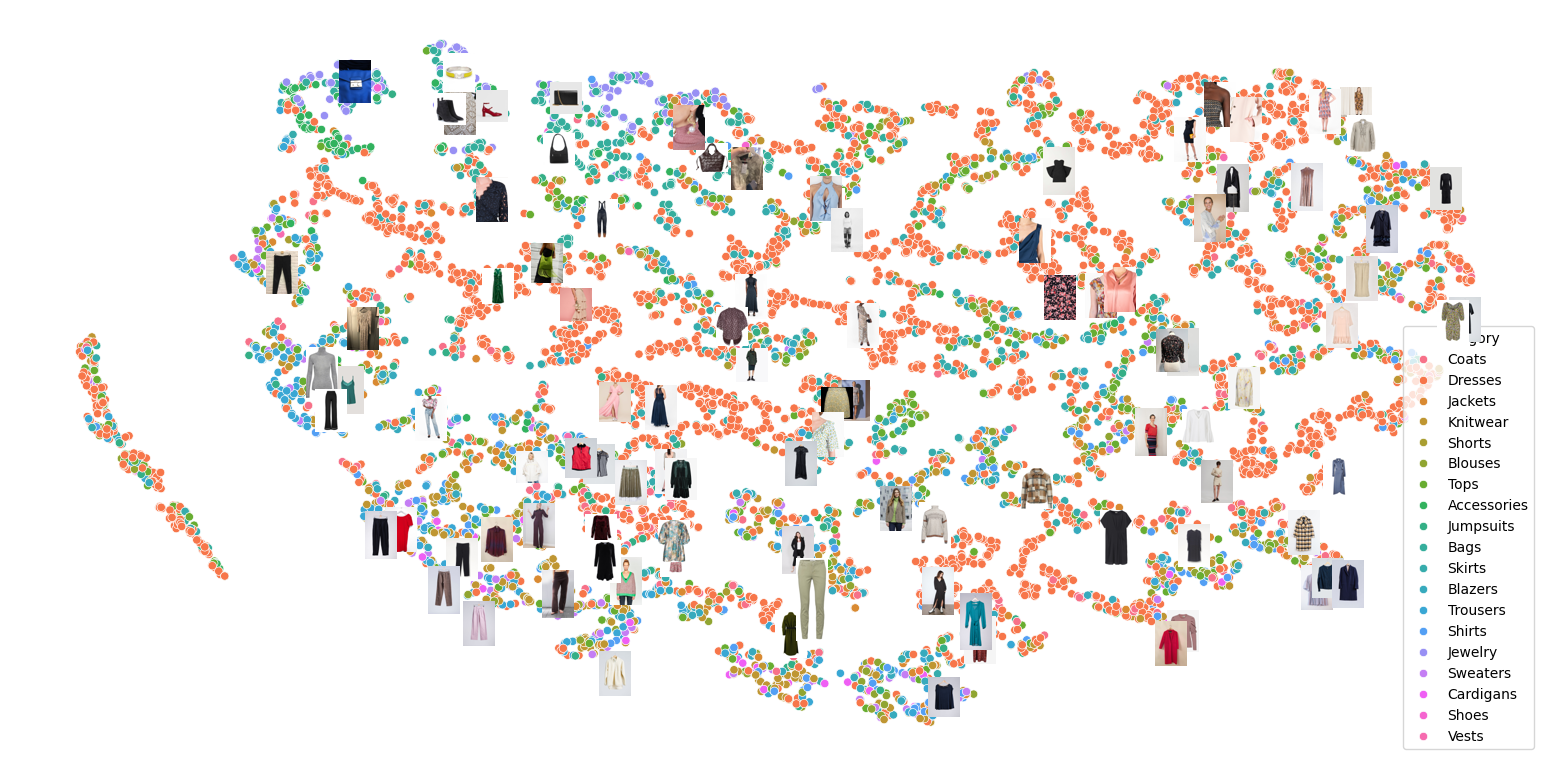

In [30]:
image_with_thumbnails = generate_embedding_tsnes_with_thumbnails.draw_thumbnails_on_scatter_plot(scatter_plot, tsne_df, num_thumbnails=100)
display(image_with_thumbnails)